In [1]:
### get data 
!wget http://www.manythings.org/anki/deu-eng.zip

--2020-07-22 10:55:56--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 172.67.173.198, 104.24.109.196, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8171564 (7.8M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   7.79M  15.6MB/s    in 0.5s    

2020-07-22 10:55:56 (15.6 MB/s) - ‘deu-eng.zip’ saved [8171564/8171564]



In [2]:
!unzip '/content/deu-eng.zip'

Archive:  /content/deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [1]:
#####import libraries 
import numpy as np 
import pandas as pd 
import os 
import pickle 
import re 
import string
from keras.applications.vgg16 import VGG16 , preprocess_input
from keras.preprocessing.image import load_img ,img_to_array 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import LSTM ,Input ,Embedding ,Dropout ,Dense
from keras.layers.merge import  add
from keras.utils.vis_utils import plot_model
from unicodedata import normalize
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
## load document
def load_doc(file):
  with open(file,mode='rt',encoding='utf-8') as f:
    text=f.read()
  return text  

In [3]:
### get english - german pairs 
def to_pairs(doc):
  lines = doc.strip().split('\n')
  pairs=[line.split('\t')[:2] for line in lines]
 
  return pairs

In [4]:
doc=load_doc('/content/deu.txt')
pairs=to_pairs(doc)


In [5]:
pairs[0]

['Go.', 'Geh.']

In [6]:
### clean pairs 
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_punc = re.compile('[%s]' % re.escape(string.punctuation))
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [re_punc.sub('', w) for w in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return np.array(cleaned,dtype=object)
   


In [7]:
def clean_input(seed):
  re_print = re.compile('[^%s]' % re.escape(string.printable)) 
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
	
  line = normalize('NFD', seed).encode('ascii', 'ignore')
  line = line.decode('UTF-8')
  # tokenize on white space
  line = line.split()
  # convert to lowercase
  line = [word.lower() for word in line]
  # remove punctuation from each token
  line = [re_punc.sub('', w) for w in line]
  # remove non-printable chars form each token
  line = [re_print.sub('', w) for w in line]
  # remove tokens with numbers in them
  line = [word for word in line if word.isalpha()]
  return ' '.join(line)
  
 


In [8]:
cleaned_pairs=clean_pairs(pairs)

In [9]:

cleaned_pairs.shape


(217032, 2)

In [10]:
def save_clean_data(sentences,filename):
  pickle.dump(sentences,open(filename,'wb'))

In [11]:
save_clean_data(cleaned_pairs,'english-german.pkl')

In [12]:
def load_clean_data(filename):
  return pickle.load(open(filename, 'rb'))

In [13]:
raw_datasets=load_clean_data('/content/english-german.pkl')

In [14]:
raw_datasets.shape

(217032, 2)

In [18]:
n_sentences = 13000
#datasets=raw_datasets[:n_sentences,:]
np.random.shuffle(raw_datasets)
datasets=raw_datasets[:n_sentences,:]

In [19]:
train, test = datasets[:12000], datasets[12000:]
print(train.shape)
print(test.shape)

(12000, 2)
(1000, 2)


In [20]:
### make tokenizer
def create_tokenizer(lines):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [21]:
## get max length 
def max_length(lines):
  return max([len(line.split()) for line in lines])

In [22]:
###encode text 
def encode_sequences(tokenizer,max_length,lines):
  encoded=tokenizer.texts_to_sequences(lines)
  padded_sequences=pad_sequences(encoded,maxlen=max_length,padding='post')
  return padded_sequences

In [23]:
### hot encode output 
def encode_output(sequences,vocab_size):
  y=list()
  for sequence in sequences:
    encoded=to_categorical(sequence,num_classes=vocab_size)
    y.append(encoded)
  y=np.array(y)
  y=y.reshape(sequences.shape[0],sequences.shape[1],vocab_size)  
  return y

In [24]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
  model=Sequential()
  model.add(Embedding(src_vocab,n_units,input_length=src_timesteps,mask_zero=True))
  model.add(LSTM(n_units))
  model.add(RepeatVector(tar_timesteps))
  model.add(LSTM(n_units,return_sequences=True))
  model.add(TimeDistributed(Dense(tar_vocab,activation='softmax')))
  model.compile(optimizer='adam', loss='categorical_crossentropy')
  return model 


In [25]:
### prepare english tokenizer 
eng_tokenizer=create_tokenizer(datasets[:,0])
eng_vocab_size=len(eng_tokenizer.word_index)+1
english_length=max_length(datasets[:,0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (english_length))

English Vocabulary Size: 5470
English Max Length: 32


In [26]:
# prepare german tokenizer
ger_tokenizer = create_tokenizer(datasets[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(datasets[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

German Vocabulary Size: 8303
German Max Length: 33


In [27]:
### prepare training data 
x_train=encode_sequences(ger_tokenizer,ger_length, train[:,1])
y_train=encode_sequences(eng_tokenizer,english_length,train[:,0])
y_train=encode_output(y_train,eng_vocab_size)

In [28]:
### prepare test  data 
x_test=encode_sequences(ger_tokenizer,ger_length, test[:,1])
y_test=encode_sequences(eng_tokenizer,english_length,test[:,0])
y_test=encode_output(y_test,eng_vocab_size)

In [29]:
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, english_length, 256)

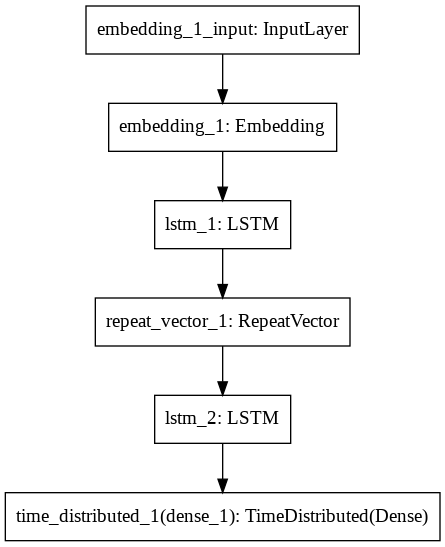

In [30]:
plot_model(model)

In [31]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [32]:
model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test), callbacks=[checkpoint], verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 12000 samples, validate on 1000 samples
Epoch 1/50
 - 41s - loss: 1.9236 - val_loss: 1.4067

Epoch 00001: val_loss improved from inf to 1.40665, saving model to model.h5
Epoch 2/50
 - 38s - loss: 1.3492 - val_loss: 1.3397

Epoch 00002: val_loss improved from 1.40665 to 1.33974, saving model to model.h5
Epoch 3/50
 - 37s - loss: 1.2821 - val_loss: 1.3090

Epoch 00003: val_loss improved from 1.33974 to 1.30904, saving model to model.h5
Epoch 4/50
 - 38s - loss: 1.2553 - val_loss: 1.3053

Epoch 00004: val_loss improved from 1.30904 to 1.30525, saving model to model.h5
Epoch 5/50
 - 38s - loss: 1.2366 - val_loss: 1.3125

Epoch 00005: val_loss did not improve from 1.30525
Epoch 6/50
 - 38s - loss: 1.2258 - val_loss: 1.3179

Epoch 00006: val_loss did not improve from 1.30525
Epoch 7/50
 - 38s - loss: 1.2143 - val_loss: 1.3053

Epoch 00007: val_loss did not improve from 1.30525
Epoch 8/50
 - 37s - loss: 1.2052 - val_loss: 1.3000

Epoch 00008: val_loss improved from 1.30525 to 1.29997

In [33]:
def word_for_int(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==integer:
      return word
  return None    

In [34]:
def predict_sequence(model, tokenizer, source):
  prediction=model.predict(source,verbose=0)[0]
  intgers=[np.argmax(vector) for vector in prediction]
  target=[]
  for i in intgers:
    word=word_for_int(i,tokenizer)
    if word is None :
      break
    target.append(word)
  return ' '.join(target)    



In [35]:
def evaluate_model(model, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append(raw_target.split())
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [36]:
from nltk.translate.bleu_score import corpus_bleu
evaluate_model(model, x_train, train)

src=[tom starb jung], target=[tom died young], predicted=[tom died young]
src=[starre mich nicht so an], target=[dont stare at me like that], predicted=[dont stare me me like me]
src=[man kann sich seine eltern nicht aussuchen], target=[you cant choose your parents], predicted=[you cant choose your parents]
src=[das zimmer wird von ihm gestrichen], target=[the room is being painted by him], predicted=[the room is painted painted by him]
src=[sie ist stolz auf ihre kinder], target=[she is proud of her children], predicted=[she is proud of her children]
src=[ich glaube nicht dass das wichtig ist], target=[i dont think it matters], predicted=[i dont think thats matters]
src=[warum bist du nicht an dein mobiltelefon gegangen], target=[why didnt you answer your cell phone], predicted=[why didnt you meet your cell]
src=[steig ins auto], target=[get into the car], predicted=[get into the car]
src=[was hast du gedacht als du mich zum ersten mal uberhaupt getroffen hast], target=[what did you t

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


src=[toms und marias kleiner junge liebt es auf dem kuchenboden zu sitzen und gegen topfe und pfannen zu schlagen], target=[tom and marys little boy loves sitting on the kitchen floor banging pots and pans], predicted=[tom and marys and and boy sitting sitting sitting sitting river banging banging banging pots pots pots pans]
BLEU-1: 0.054567
BLEU-2: 0.000929
BLEU-3: 0.015169
BLEU-4: 0.030488


In [67]:
### inference 
seed_text='Mir ist es wichtig'
s=clean_input(seed_text)
encoded=ger_tokenizer.texts_to_sequences([s])[0]
padded=pad_sequences([encoded],maxlen=ger_length,padding='post')
#source = source.reshape((1, source.shape[0]))
translation = predict_sequence(model, eng_tokenizer, padded)



In [68]:
translation

'i tried'

In [37]:
def inference(seed_text):
  cleaned_text=clean_input(seed_text)
  encoded=ger_tokenizer.texts_to_sequences([cleaned_text])[0]
  padded=pad_sequences([encoded],maxlen=ger_length,padding='post')
  #source = source.reshape((1, source.shape[0]))
  translation = predict_sequence(model, eng_tokenizer, padded)
  return translation 




In [44]:
print(inference('Es tut mir leid'))

i sorry sorry sorry
